1.做Feature extraction


In [537]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [538]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [539]:
batch_size = 32
img_height = 160
img_width = 160
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [540]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [541]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
AUTOTUNE = tf.data.AUTOTUNE

In [542]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [543]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

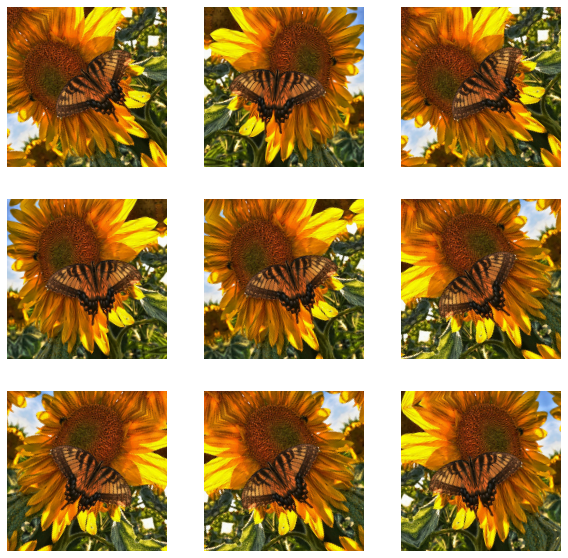

In [544]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [545]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [546]:
rescale = tf.keras.layers.Rescaling(1./255)

In [547]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [548]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [549]:
base_model.trainable = False

In [550]:
# Let's take a look at the base model architecture
#base_model.summary()

In [551]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [552]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [553]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [554]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [555]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_19 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_27 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_27 (TFOpLa  (None, 160, 160, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                          

In [556]:
len(model.trainable_variables)

2

In [557]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(val_ds)

23/23 [==============================] - 4s 62ms/step - loss: 1.9336 - accuracy: 0.2139


In [558]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
92/92 [==============================] - 12s 88ms/step - loss: 1.6798 - accuracy: 0.3283 - val_loss: 1.3256 - val_accuracy: 0.4428
Epoch 2/15
92/92 [==============================] - 8s 88ms/step - loss: 1.2529 - accuracy: 0.4990 - val_loss: 1.0087 - val_accuracy: 0.6322
Epoch 3/15
92/92 [==============================] - 8s 87ms/step - loss: 0.9963 - accuracy: 0.6253 - val_loss: 0.8354 - val_accuracy: 0.7166
Epoch 4/15
92/92 [==============================] - 8s 88ms/step - loss: 0.8672 - accuracy: 0.6778 - val_loss: 0.7271 - val_accuracy: 0.7725
Epoch 5/15
92/92 [==============================] - 8s 88ms/step - loss: 0.7874 - accuracy: 0.7112 - val_loss: 0.6573 - val_accuracy: 0.7861
Epoch 6/15
92/92 [==============================] - 8s 87ms/step - loss: 0.6803 - accuracy: 0.7609 - val_loss: 0.6031 - val_accuracy: 0.8052
Epoch 7/15
92/92 [==============================] - 8s 86ms/step - loss: 0.6450 - accuracy: 0.7732 - val_loss: 0.5649 - val_accuracy: 0.8270
Epoch 8/15
9

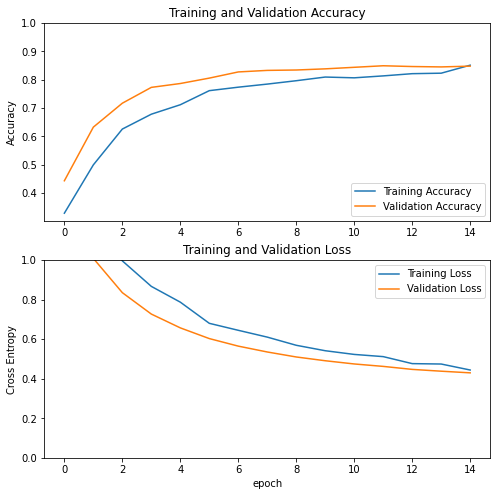

In [559]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

2.做Fine-Tuning

In [560]:
base_model.trainable = True

In [561]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [562]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [563]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_19 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_27 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_27 (TFOpLa  (None, 160, 160, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                          

In [564]:
len(model.trainable_variables)

56

In [565]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 15/25
92/92 [==============================] - 18s 120ms/step - loss: 0.4213 - accuracy: 0.8416 - val_loss: 0.3773 - val_accuracy: 0.8529
Epoch 16/25
92/92 [==============================] - 10s 107ms/step - loss: 0.3652 - accuracy: 0.8590 - val_loss: 0.3450 - val_accuracy: 0.8774
Epoch 17/25
92/92 [==============================] - 10s 106ms/step - loss: 0.3075 - accuracy: 0.8811 - val_loss: 0.3189 - val_accuracy: 0.8787
Epoch 18/25
92/92 [==============================] - 10s 107ms/step - loss: 0.2920 - accuracy: 0.8869 - val_loss: 0.2954 - val_accuracy: 0.8896
Epoch 19/25
92/92 [==============================] - 10s 108ms/step - loss: 0.2589 - accuracy: 0.9012 - val_loss: 0.3053 - val_accuracy: 0.8883
Epoch 20/25
92/92 [==============================] - 10s 108ms/step - loss: 0.2430 - accuracy: 0.9121 - val_loss: 0.2889 - val_accuracy: 0.8924
Epoch 21/25
92/92 [==============================] - 10s 108ms/step - loss: 0.2235 - accuracy: 0.9186 - val_loss: 0.2874 - val_accuracy:

In [566]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

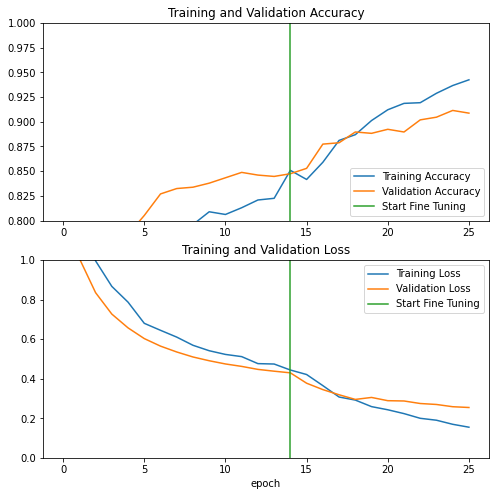

In [567]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(2)做RESNET50

In [569]:
batch_size = 32
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [570]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
AUTOTUNE = tf.data.AUTOTUNE

In [571]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [572]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [576]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SHAPE), include_top= 'False', weights='imagenet')

In [577]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [578]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [584]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
#x = tf.keras.layers.GlobalAveragePooling2D(x)
x = tf.keras.layers.Flatten()(x)

#x = tf.keras.layers.Dense(1000)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

ValueError: ignored

結論：
前面feature與fine-tuning跑了大概20個組合有，但準確度一直卡在90上下（最高推到92）嘗試過增加多的訓練變數提升一點點，很容易發生overfitting的現象。我覺得造成此主要原因是因為資料個數可能不夠多。
